In [ ]:
import pandas as pd
import numpy as np
import os
import tqdm

import torch
from torch.nn import CosineSimilarity

def cosine_sim(x,y):
    cos = CosineSimilarity(dim=1, eps=1e-6)
    coef_of_similarity = cos(torch.tensor(x.reshape(1,-1).astype('float64')), torch.tensor(y.reshape(1,-1).astype('float64')))
    return coef_of_similarity

os.environ['JAVAHOME'] = "C:/Program Files/Java/jre1.8.0_341/bin/java.exe"

In [ ]:
train = pd.read_csv('C:/datasets/nlp-getting-started/train.csv')
test = pd.read_csv('C:/datasets/nlp-getting-started/test.csv')

In [ ]:
train['keyword'].describe(), test['keyword'].describe()

In [ ]:
train['keyword'].isna().mean(), test['keyword'].isna().mean()

In [ ]:
non_nan_indexes_train = train['keyword'].notnull()[train['keyword'].notnull() == True].index
for value in train['keyword'].loc[non_nan_indexes_train].values:
    if '%20' in value:
        for i in train['keyword'][train['keyword'] == value].index:
            train.loc[i,'keyword'] = train.loc[i,'keyword'].replace('%20', ' ')

In [ ]:
for value in tqdm.tqdm(train['keyword'].loc[non_nan_indexes_train].values):
    if len(value.split(' ')) == 2:
        for i in train['keyword'][train['keyword'] == value].index:
            train.loc[i,'keyword'] = train.loc[i,'keyword'].split(' ')[1]
    elif len(value.split(' ')) == 3:
        for i in train['keyword'][train['keyword'] == value].index:
            train.loc[i,'keyword'] = train.loc[i,'keyword'].split(' ')[0]
    elif len(value.split(' ')) == 1:
        for i in train['keyword'][train['keyword'] == value].index:
            train.loc[i,'keyword'] = train.loc[i,'keyword'].split(' ')[0]

In [ ]:
train['keyword'].unique()[105:110]

In [ ]:
non_nan_indexes_test = test['keyword'].notnull()[test['keyword'].notnull() == True].index
for value in test['keyword'].loc[non_nan_indexes_test].values:
    if '%20' in value:
        for i in test['keyword'][test['keyword'] == value].index:
            test.loc[i,'keyword'] = test.loc[i,'keyword'].replace('%20', ' ')

In [ ]:
for value in tqdm.tqdm(test['keyword'].loc[non_nan_indexes_test].values):
    if len(value.split(' ')) == 2:
        for i in test['keyword'][test['keyword'] == value].index:
            test.loc[i,'keyword'] = test.loc[i,'keyword'].split(' ')[1]
    elif len(value.split(' ')) == 3:
        for i in test['keyword'][test['keyword'] == value].index:
            test.loc[i,'keyword'] = test.loc[i,'keyword'].split(' ')[0]
    elif len(value.split(' ')) == 1:
        for i in test['keyword'][test['keyword'] == value].index:
            test.loc[i,'keyword'] = test.loc[i,'keyword'].split(' ')[0]

In [ ]:
train['keyword'] = train['keyword'].replace('bioterror', 'terror')
test['keyword'] = test['keyword'].replace('bioterror', 'terror')
train['keyword'] = train['keyword'].replace('bioterrorism', 'terrorism')
test['keyword'] = test['keyword'].replace('bioterrorism', 'terrorism')
train['keyword'] = train['keyword'].replace('inundation', 'flooding')
test['keyword'] = test['keyword'].replace('inundation', 'flooding')

In [ ]:
test['keyword'].unique()[105:110]

In [ ]:
set(train['keyword'].unique()) - set(test['keyword'].unique()), set(test['keyword'].unique()) - set(train['keyword'].unique())

In [ ]:
keywords_to_word2vec = list(set(np.hstack((train.loc[non_nan_indexes_train,'keyword'].unique(), test.loc[non_nan_indexes_test,'keyword'].unique()))))
keywords_to_word2vec = sorted(keywords_to_word2vec)
keywords_to_word2vec[100:115]

In [ ]:
import gensim.downloader as api
vector_size = 25
info = api.info()  # show info about available models/datasets
model = api.load("glove-twitter-25")  # download the model and return as object ready for use

In [ ]:
model.most_similar("truck")

In [ ]:
cosine_sim(model.get_vector('flame'), model.get_vector('fire'))

In [ ]:
model.get_vector('terror')

In [ ]:
dict_word2vec = dict()
for word in keywords_to_word2vec:
    dict_word2vec[word] = model.get_vector(word)

In [ ]:
word_vec = pd.DataFrame();
temp = pd.DataFrame({'word':[]})
word_vec = pd.concat([word_vec, temp])
for i in range(vector_size):
    temp = pd.DataFrame({f'word_x{i+1}':[]})
    word_vec = pd.concat([word_vec, temp])

In [ ]:
for word, values in tqdm.tqdm(dict_word2vec.items()):
    temp = pd.DataFrame({'word':[word]})
    word_vec = pd.concat([word_vec, temp])
word_vec = word_vec.reset_index().drop('index',axis=1)

In [ ]:
for word, values in tqdm.tqdm(dict_word2vec.items()):
    indx = word_vec['word'][word_vec['word'] == word].index
    for i in range(word_vec.columns[1:].shape[0]):
        word_vec.loc[indx, word_vec.columns[1:][i]] = dict_word2vec[word][i]

In [ ]:
train[word_vec.columns[1:]] = np.nan
train[word_vec.columns[1:]] = train[word_vec.columns[1:]].astype('float32')
test[word_vec.columns[1:]] = np.nan
test[word_vec.columns[1:]] = test[word_vec.columns[1:]].astype('float32')

In [ ]:
for word in tqdm.tqdm(word_vec['word'].values):
    for ind in train['keyword'][train['keyword'] == word].index:
        ind_wrd = word_vec['word'][word_vec['word'] == word].index.item()
        train.loc[ind,word_vec.columns[1:]] = word_vec.loc[ind_wrd, word_vec.columns[1:]]

In [ ]:
for word in tqdm.tqdm(word_vec['word'].values):
    for ind in test['keyword'][test['keyword'] == word].index:
        ind_wrd = word_vec['word'][word_vec['word'] == word].index.item()
        test.loc[ind,word_vec.columns[1:]] = word_vec.loc[ind_wrd, word_vec.columns[1:]]

In [ ]:
# next feature extraction

In [ ]:
import string
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from nltk.tag.stanford import StanfordNERTagger # location filter
PATH_TO_JAR='C:/Users/TimurRashitov/stanford-ner-2020-11-17/stanford-ner.jar' # location filter data
PATH_TO_MODEL = 'C:/Users/TimurRashitov/stanford-ner-2020-11-17/classifiers/english.all.3class.distsim.crf.ser.gz' # location filter model
tagger = StanfordNERTagger(model_filename=PATH_TO_MODEL,path_to_jar=PATH_TO_JAR, encoding='utf-8')
# EXAMPLE OF LOCATION EXTRACTION WITH STANFORD NER 
# words = nltk.word_tokenize('I Love Britain')
# tagged = tagger.tag(words)
# [('I', 'O'), ('Love', 'O'), ('Britain', 'LOCATION')]


tt = TweetTokenizer()
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

def clean_text_location(text):
    text_nonum = re.sub(r'\d+', '', text)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation]) 
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    sent = re.sub('\s+', ' ', text_nopunct).strip()
    # keep only letters
    sent = re.sub(r'[^a-zA-Z]', ' ', sent)
    return sent

def lematize_remove_stopwords_and_punctuation_in_tokenized_sentence(text):
    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation]) 
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    sent = re.sub('\s+', ' ', text_nopunct).strip()
    sent = re.sub(r'[^a-zA-Z]', ' ', sent)
    sent = tt.tokenize(sent)
    for i in range(len(sent)):
        sent[i] = lemmatizer.lemmatize(sent[i], wordnet.VERB)
    filtered_sentence = []
    for w in sent:
        if w not in stop_words:
            filtered_sentence.append(w)
    return filtered_sentence

In [ ]:
train['location'].value_counts()

In [ ]:
non_nan_indexes_train = train['location'].notnull()[train['location'].notnull() == True].index
non_nan_indexes_test = test['location'].notnull()[test['location'].notnull() == True].index

In [ ]:
train['location'].isna().sum()

In [ ]:
train['location']

In [ ]:
train.loc[non_nan_indexes_train, 'location'].unique()[1000:2000]

In [ ]:
for ind in non_nan_indexes_train:
    train.loc[ind, 'location'] = clean_text_location(train.loc[ind, 'location'])

In [ ]:
for ind in non_nan_indexes_test:
    test.loc[ind, 'location'] = clean_text_location(test.loc[ind, 'location'])

In [ ]:
for ind in non_nan_indexes_train:
    processed_sentence = lematize_remove_stopwords_and_punctuation_in_tokenized_sentence(train.loc[ind, 'location'])
    for k in range(len(processed_sentence)):
        processed_sentence[k] = processed_sentence[k].capitalize()
    processed_sentence = ' '.join(processed_sentence)
    train.loc[ind, 'location'] = processed_sentence

In [ ]:
for ind in non_nan_indexes_test:
    processed_sentence = lematize_remove_stopwords_and_punctuation_in_tokenized_sentence(test.loc[ind, 'location'])
    for k in range(len(processed_sentence)):
        processed_sentence[k] = processed_sentence[k].capitalize()
    processed_sentence = ' '.join(processed_sentence)
    test.loc[ind, 'location'] = processed_sentence

In [ ]:
len(train.loc[non_nan_indexes_train,'location'].unique()), len(test.loc[non_nan_indexes_test,'location'].unique())

In [ ]:
sentences_to_embeddings = list(set(np.hstack((train.loc[non_nan_indexes_train,'location'].unique(), test.loc[non_nan_indexes_test,'location'].unique()))))
sentences_to_embeddings = sorted(sentences_to_embeddings)
len(sentences_to_embeddings)

In [ ]:
sentences_to_embeddings[980:1000]

In [ ]:
train.loc[34, 'location']

In [ ]:
train.loc[non_nan_indexes_train,'location'].unique().tolist()[3]

In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('stsb-mpnet-base-v2')
vector_size = 768

In [ ]:
embeddings = sbert_model.encode(sentences_to_embeddings)

In [ ]:
# sent = ' '.join(['England', 'Great', 'Britain', 'Emirates'])
# sent_vec = sbert_model.encode([sent])
# query = ' '.join(['England', 'Great', 'Britain'])
# query_vec = sbert_model.encode([query])

import torch
from torch.nn import CosineSimilarity
def cosine_sim(x,y):
    cos = CosineSimilarity(dim=1, eps=1e-6)
    coef_of_similarity = cos(torch.tensor(x.reshape(1,-1).astype('float64')), torch.tensor(y.reshape(1,-1).astype('float64')))
    return coef_of_similarity

In [ ]:
len(sentences_to_embeddings)

In [ ]:
embeddings.shape

In [ ]:
wordpairs_2vec = dict()
for index in range(len(sentences_to_embeddings)):
    wordpairs_2vec[sentences_to_embeddings[index]] = embeddings[index]

In [ ]:
# wordpairs_vec = pd.DataFrame();
# temp = pd.DataFrame({'wordpair':[]})
# wordpairs_vec = pd.concat([wordpairs_vec, temp])
# for i in range(vector_size):
#     temp = pd.DataFrame({f'x{i+1}':[]})
#     wordpairs_vec = pd.concat([wordpairs_vec, temp])

In [ ]:
# for wordpair, values in tqdm.tqdm(wordpairs_2vec.items()):
#     temp = pd.DataFrame({'wordpair':[wordpair]})
#     wordpairs_vec = pd.concat([wordpairs_vec, temp])
# wordpairs_vec = wordpairs_vec.reset_index().drop('index',axis=1)

In [ ]:
# for wordpair, values in tqdm.tqdm(wordpairs_2vec.items()):
#     indx = wordpairs_vec['wordpair'][wordpairs_vec['wordpair'] == wordpair].index
#     for i in range(wordpairs_vec.columns[1:].shape[0]):
#         wordpairs_vec.loc[indx, wordpairs_vec.columns[1:][i]] = wordpairs_2vec[wordpair][i]

In [ ]:
wordpairs_vec = pd.read_csv('C:/datasets/nlp-getting-started/location_embeddings.csv')

In [ ]:
wordpairs_vec[wordpairs_vec.columns[1:]] = wordpairs_vec[wordpairs_vec.columns[1:]].astype('float64')

In [ ]:
cosine_sim(wordpairs_vec.loc[1012,wordpairs_vec.columns[1:]].values, wordpairs_vec.loc[1013,wordpairs_vec.columns[1:]].values)

In [ ]:
train[wordpairs_vec.columns[1:]] = np.nan
train[wordpairs_vec.columns[1:]] = train[wordpairs_vec.columns[1:]].astype('float32')
test[wordpairs_vec.columns[1:]] = np.nan
test[wordpairs_vec.columns[1:]] = test[wordpairs_vec.columns[1:]].astype('float32')

In [ ]:
for wordpair in tqdm.tqdm(wordpairs_vec['wordpair'].values):
    for ind in train['location'][train['location'] == wordpair].index:
        ind_wrd = wordpairs_vec['wordpair'][wordpairs_vec['wordpair'] == wordpair].index.item()
        train.loc[ind,wordpairs_vec.columns[1:]] = wordpairs_vec.loc[ind_wrd, wordpairs_vec.columns[1:]]

In [ ]:
for wordpair in tqdm.tqdm(wordpairs_vec['wordpair'].values):
    for ind in test['location'][test['location'] == wordpair].index:
        ind_wrd = wordpairs_vec['wordpair'][wordpairs_vec['wordpair'] == wordpair].index.item()
        test.loc[ind,wordpairs_vec.columns[1:]] = wordpairs_vec.loc[ind_wrd, wordpairs_vec.columns[1:]]

In [ ]:
# text feature

In [ ]:
def clean_text_text(text):
    text_nonum = re.sub(r'\d+', '', text)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation]) 
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    sent = re.sub('\s+', ' ', text_nopunct).strip()
    # keep only letters
    sent = re.sub(r'[^a-zA-Z]', ' ', sent)
    return sent

def lematize_remove_stopwords_and_punctuation_in_tokenized_text(text):
    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation]) 
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    sent = re.sub('\s+', ' ', text_nopunct).strip()
    sent = re.sub(r'[^a-zA-Z]', ' ', sent)
    sent = tt.tokenize(sent)
    for i in range(len(sent)):
        sent[i] = lemmatizer.lemmatize(sent[i], wordnet.VERB)
    filtered_sentence = []
    for w in sent:
        if w not in stop_words:
            filtered_sentence.append(w)
    return filtered_sentence

In [ ]:
train['text'].value_counts()

In [ ]:
non_nan_indexes_train = train['text'].notnull()[train['text'].notnull() == True].index
non_nan_indexes_test = test['text'].notnull()[test['text'].notnull() == True].index

In [ ]:
train['text'].isna().sum()

In [ ]:
test['text'].isna().sum()

In [ ]:
train.loc[non_nan_indexes_train, 'text'].unique()[150]

In [ ]:
for ind in non_nan_indexes_train:
    train.loc[ind, 'text'] = clean_text_text(train.loc[ind, 'text'])

In [ ]:
for ind in non_nan_indexes_test:
    test.loc[ind, 'text'] = clean_text_text(test.loc[ind, 'text'])

In [ ]:
train.loc[non_nan_indexes_train, 'text'].unique()[150]

In [ ]:
for ind in tqdm.tqdm(non_nan_indexes_train):
    processed_sentence = lematize_remove_stopwords_and_punctuation_in_tokenized_sentence(train.loc[ind, 'text'])
    processed_sentence = ' '.join(processed_sentence)
    train.loc[ind, 'text'] = processed_sentence

In [ ]:
for ind in tqdm.tqdm(non_nan_indexes_test):
    processed_sentence = lematize_remove_stopwords_and_punctuation_in_tokenized_sentence(test.loc[ind, 'text'])
    processed_sentence = ' '.join(processed_sentence)
    test.loc[ind, 'text'] = processed_sentence

In [ ]:
train.loc[non_nan_indexes_train, 'text'].unique()[150]

In [ ]:
len(train.loc[non_nan_indexes_train,'text'].unique()), len(test.loc[non_nan_indexes_test,'text'].unique())

In [ ]:
text_to_embeddings = list(set(np.hstack((train.loc[non_nan_indexes_train,'text'].unique(), test.loc[non_nan_indexes_test,'text'].unique()))))
text_to_embeddings = sorted(text_to_embeddings)
len(text_to_embeddings)

In [ ]:
text_to_embeddings[980:1000]

In [ ]:
train.loc[12, 'text']

In [ ]:
train.loc[non_nan_indexes_train,'text'].unique().tolist()[12]

In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('stsb-mpnet-base-v2')
vector_size = 768

In [ ]:
embeddings = sbert_model.encode(text_to_embeddings)

In [ ]:
# sent = ' '.join(['England', 'Great', 'Britain', 'Emirates'])
# sent_vec = sbert_model.encode([sent])
# query = ' '.join(['England', 'Great', 'Britain'])
# query_vec = sbert_model.encode([query])

In [ ]:
len(text_to_embeddings)

In [ ]:
embeddings.shape

In [ ]:
text_2vec = dict()
for index in tqdm.tqdm(range(len(text_to_embeddings))):
    text_2vec[text_to_embeddings[index]] = embeddings[index]

In [ ]:
# text_vec = pd.DataFrame();
# temp = pd.DataFrame({'text_contain':[]})
# text_vec = pd.concat([text_vec, temp])
# for i in tqdm.tqdm(range(vector_size)):
#     temp = pd.DataFrame({f'text{i+1}':[]})
#     text_vec = pd.concat([text_vec, temp])

In [ ]:
# for text, values in tqdm.tqdm(text_2vec.items()):
#     temp = pd.DataFrame({'text_contain':[text]})
#     text_vec = pd.concat([text_vec, temp])
# text_vec = text_vec.reset_index().drop('index',axis=1)

In [ ]:
# for text, values in tqdm.tqdm(text_2vec.items()):
#     indx = text_vec['text_contain'][text_vec['text_contain'] == text].index
#     for i in range(text_vec.columns[1:].shape[0]):
#         text_vec.loc[indx, text_vec.columns[1:][i]] = text_2vec[text][i]

In [ ]:
text_vec = pd.read_csv('C:/datasets/nlp-getting-started/text_embeddings.csv')

In [ ]:
text_vec[text_vec.columns[1:]] = text_vec[text_vec.columns[1:]].astype('float64')

In [ ]:
text_vec.loc[1012,text_vec.columns[:1]].item(), text_vec.loc[1013,text_vec.columns[:1]].item()

In [ ]:
text_vec.loc[1012,'text_contain'], text_vec.loc[1013,'text_contain']

In [ ]:
train[text_vec.columns[1:]] = np.nan
train[text_vec.columns[1:]] = train[text_vec.columns[1:]].astype('float32')
test[text_vec.columns[1:]] = np.nan
test[text_vec.columns[1:]] = test[text_vec.columns[1:]].astype('float32')

In [ ]:
for text in tqdm.tqdm(text_vec['text_contain'].values):
    for ind in train['text'][train['text'] == text].index:
        ind_wrd = text_vec['text_contain'][text_vec['text_contain'] == text].index.item()
        train.loc[ind,text_vec.columns[1:]] = text_vec.loc[ind_wrd, text_vec.columns[1:]]

In [ ]:
for text in tqdm.tqdm(text_vec['text_contain'].values):
    for ind in test['text'][test['text'] == text].index:
        ind_wrd = text_vec['text_contain'][text_vec['text_contain'] == text].index.item()
        test.loc[ind,text_vec.columns[1:]] = text_vec.loc[ind_wrd, text_vec.columns[1:]]

In [ ]:
train.loc[non_nan_indexes_train,['text'] + text_vec.columns[1:].tolist()].loc[10:20]

In [ ]:
cosine_sim(train.loc[non_nan_indexes_train,text_vec.columns[1:]].loc[10].values, train.loc[non_nan_indexes_train,text_vec.columns[1:]].loc[11].values)

In [ ]:
cosine_sim(sbert_model.encode(train.loc[non_nan_indexes_train,'text'].loc[10]),sbert_model.encode(train.loc[non_nan_indexes_train,'text'].loc[11]))

In [ ]:
# train.to_csv('C:/datasets/nlp-getting-started/prepared_not_imputed_train.csv', index=False)

# test.to_csv('C:/datasets/nlp-getting-started/prepared_not_imputed_test.csv', index=False)

In [ ]:
################# Imputation

In [ ]:
train_data = train.copy()
test_data = test.copy()

In [ ]:
non_nan_train_indexes = train['location'].notnull()[train['location'].notnull() == True].index
to_fit_X = train_data.loc[non_nan_train_indexes, text_vec.columns[1:]]
to_fit_y = train_data.loc[non_nan_train_indexes, wordpairs_vec.columns[1:]]
non_nan_train_indexes = list(set(non_nan_train_indexes) - set(to_fit_y['x1'][to_fit_y['x1'].isna() == True].index))
to_fit_X = train_data.loc[non_nan_train_indexes, text_vec.columns[1:]]
to_fit_y = train_data.loc[non_nan_train_indexes, wordpairs_vec.columns[1:]]

In [ ]:
nan_train_indexes = train_data['location'][train_data['location'].isna() == True].index
to_predict_X = train_data.loc[nan_train_indexes, text_vec.columns[1:]]
to_predict_y = train_data.loc[nan_train_indexes, wordpairs_vec.columns[1:]]

In [ ]:
remain_index = to_predict_y.index

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor(n_neighbors=20)

In [ ]:
knn_reg.fit(to_fit_X, to_fit_y)

In [ ]:
to_predict_y = pd.DataFrame(knn_reg.predict(to_predict_X), columns=to_predict_y.columns)

In [ ]:
to_predict_y.index = remain_index

In [ ]:
train_data.loc[nan_train_indexes, wordpairs_vec.columns[1:]] = to_predict_y

In [ ]:
residual_index = train_data[wordpairs_vec.columns[1]][train_data[wordpairs_vec.columns[1]].isna() == True].index

In [ ]:
temp = pd.DataFrame(knn_reg.predict(train_data.loc[residual_index, text_vec.columns[1:]]), columns=to_predict_y.columns)  

In [ ]:
temp.index = residual_index

In [ ]:
train_data.loc[residual_index, wordpairs_vec.columns[1:]] = temp

In [ ]:
## another Imputation

In [ ]:
non_nan_train_indexes = train['keyword'].notnull()[train['keyword'].notnull() == True].index
to_fit_X = train_data.loc[non_nan_train_indexes, text_vec.columns[1:]]
to_fit_y = train_data.loc[non_nan_train_indexes, word_vec.columns[1:]]

In [ ]:
nan_train_indexes = train_data['keyword'][train_data['keyword'].isna() == True].index
to_predict_X = train_data.loc[nan_train_indexes, text_vec.columns[1:]]
to_predict_y = train_data.loc[nan_train_indexes, word_vec.columns[1:]]

In [ ]:
remain_index = to_predict_y.index

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor(n_neighbors=20)

In [ ]:
knn_reg.fit(to_fit_X, to_fit_y)

In [ ]:
to_predict_y = pd.DataFrame(knn_reg.predict(to_predict_X), columns=to_predict_y.columns)

In [ ]:
to_predict_y.index = remain_index

In [ ]:
train_data.loc[nan_train_indexes, word_vec.columns[1:]] = to_predict_y

In [ ]:
train_data.drop(['id','keyword','location','text'], axis=1).isna().sum().mean()

In [ ]:
###### Test imputation

In [ ]:
non_nan_test_indexes = test['location'].notnull()[test['location'].notnull() == True].index
to_fit_X = test_data.loc[non_nan_test_indexes, text_vec.columns[1:]]
to_fit_y = test_data.loc[non_nan_test_indexes, wordpairs_vec.columns[1:]]

In [ ]:
nan_test_indexes = test_data['location'][test_data['location'].isna() == True].index
to_predict_X = test_data.loc[nan_test_indexes, text_vec.columns[1:]]
to_predict_y = test_data.loc[nan_test_indexes, wordpairs_vec.columns[1:]]

In [ ]:
to_fit_X.isna().sum().mean(), to_fit_y.isna().sum().mean()

In [ ]:
non_empty_indx = to_fit_y.isna()['x1'][to_fit_y.isna()['x1'] == False].index

In [ ]:
empty_indx = to_fit_y.isna()['x1'][to_fit_y.isna()['x1'] == True].index

In [ ]:
knn_reg.fit(to_fit_X.loc[non_empty_indx], to_fit_y.loc[non_empty_indx])

In [ ]:
to_fit_y = pd.DataFrame(knn_reg.predict(to_fit_X.loc[empty_indx]), columns=to_fit_y.columns)

to_fit_y.index = empty_indx

In [ ]:
test_data.loc[empty_indx, wordpairs_vec.columns[1:]] = to_fit_y

In [ ]:
to_fit_X = test_data.loc[non_nan_test_indexes, text_vec.columns[1:]]
to_fit_y = test_data.loc[non_nan_test_indexes, wordpairs_vec.columns[1:]]

In [ ]:
to_fit_X.isna().sum().mean(), to_fit_y.isna().sum().mean()

In [ ]:
remain_index = to_predict_y.index

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor(n_neighbors=20)

In [ ]:
knn_reg.fit(to_fit_X, to_fit_y)

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
test_data.loc[nan_test_indexes, text_vec.columns[1:]] = imputer.fit_transform(to_predict_X)
to_predict_X = test_data.loc[nan_test_indexes, text_vec.columns[1:]]

In [ ]:
to_predict_y = pd.DataFrame(knn_reg.predict(to_predict_X), columns=to_predict_y.columns)

In [ ]:
to_predict_y.index = remain_index

In [ ]:
test_data.loc[nan_test_indexes, wordpairs_vec.columns[1:]] = to_predict_y

In [ ]:
test_data[wordpairs_vec.columns[1:]].isna().sum().mean()

In [ ]:
test_data.drop(['id','keyword','location','text'], axis=1).isna().sum().mean()

In [ ]:
non_nan_test_indexes = test['keyword'].notnull()[test['keyword'].notnull() == True].index
to_fit_X = test_data.loc[non_nan_test_indexes, text_vec.columns[1:]]
to_fit_y = test_data.loc[non_nan_test_indexes, word_vec.columns[1:]]

In [ ]:
nan_test_indexes = test_data['keyword'][test_data['keyword'].isna() == True].index
to_predict_X = test_data.loc[nan_test_indexes, text_vec.columns[1:]]
to_predict_y = test_data.loc[nan_test_indexes, word_vec.columns[1:]]

In [ ]:
to_fit_X.isna().sum().mean(), to_fit_y.isna().sum().mean()

In [ ]:
knn_reg.fit(to_fit_X, to_fit_y)

In [ ]:
old_index = to_predict_y.index

In [ ]:
to_predict_y = pd.DataFrame(knn_reg.predict(to_predict_X), columns=to_predict_y.columns)

to_predict_y.index = old_index

In [ ]:
test_data.loc[nan_test_indexes, word_vec.columns[1:]] = to_predict_y

In [ ]:
train_data.drop(['id','keyword','location','text'], axis=1).isna().sum().mean(), test_data.drop(['id','keyword','location','text'], axis=1).isna().sum().mean()

In [1]:
import pandas as pd
import numpy as np
# train_data.to_csv('C:/datasets/nlp-getting-started/prepared_imputed_train.csv', index=False)

# test_data.to_csv('C:/datasets/nlp-getting-started/prepared_imputed_test.csv', index=False)

train_data = pd.read_csv('C:/datasets/nlp-getting-started/prepared_imputed_train.csv')
test_data = pd.read_csv('C:/datasets/nlp-getting-started/prepared_imputed_test.csv')

In [2]:
# TRAINING

In [3]:
train_data = train_data.drop(['id','keyword', 'location', 'text'], axis=1)
test_data = test_data.drop(['id','keyword', 'location', 'text'], axis=1)

In [4]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, classification_report, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

In [ ]:
target = train_data['target'].values
features = train_data.drop('target', axis=1).values

In [152]:
features.shape

(7613, 1561)

In [153]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1593,random_state=17)

In [154]:
X_train = torch.tensor(X_train).float().cuda(); X_train.shape

torch.Size([6400, 1561])

In [155]:
y_train = torch.tensor(y_train).view(-1,1).float().cuda(); y_train.shape

torch.Size([6400, 1])

In [156]:
X_test = torch.tensor(X_test).float().cuda(); X_test.shape

torch.Size([1213, 1561])

In [157]:
y_test = torch.tensor(y_test).view(-1,1).float().cuda(); y_test.shape

torch.Size([1213, 1])

In [223]:
model = nn.Sequential(nn.Linear(1561,1024),
                      nn.ReLU(),
                      nn.Dropout(0.25),
                      nn.Linear(1024,1024),
                      nn.ReLU(),
                      nn.Dropout(0.25),
                      nn.Linear(1024,1024),
                      nn.ReLU(),
                      nn.Dropout(0.25),
                      nn.Linear(1024,1024),
                      nn.ReLU(),
                      nn.Dropout(0.25),
                      nn.Linear(1024,1024),
                      nn.ReLU(),
                      nn.Dropout(0.25),
                      nn.Linear(1024,1),
                      nn.Sigmoid()).to('cuda')

In [232]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.00002, momentum=0.9)

In [225]:
threshold = 0.5

probs = model(X_test).cpu().data.numpy()
preds = (probs > threshold).astype('int64')
print(f'accuracy_test: {accuracy_score(y_test.cpu(), preds)}')
print(f'roc_auc_test: {roc_auc_score(y_test.cpu(), probs)}')
print(confusion_matrix(y_test.cpu(), preds))

accuracy_test: 0.5655399835119538
roc_auc_test: 0.5053450556505665
[[669  18]
 [509  17]]


In [234]:
average_f1_min = 0.802415
epochs = 200
for e in range(epochs):    
    model.train()
    counter = 0
    for i in range(0,100):
        counter += 64
        X_batch = X_train[counter-64:counter]
        y_batch = y_train[counter-64:counter]
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    loss = criterion(model(X_test), y_test)
    probs = model(X_test).cpu().data.numpy()
    fpr, tpr, thr = roc_curve(y_test.cpu(), probs)
    roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thr':thr});
    roc['random'] = roc['fpr'].copy()
    roc['diff'] = roc['tpr'] - roc['fpr']
    roc = roc.sort_values('diff', ascending=False).reset_index().drop('index', axis=1)
    preds = (probs >= roc['thr'].loc[0]).astype('int64')
    average_f1_ = f1_score(y_test.cpu(), preds, average='macro')    
    print(f"test loss of {e}th epoch number: {loss}, f1_score_: {average_f1_}")
    if average_f1_ >= average_f1_min:
        print('f1 score increased ({:.6f} --> {:.6f}).  Saving model ...'.format(average_f1_min, average_f1_))
        torch.save(model.state_dict(), 'model_NLP.pt')
        average_f1_min = average_f1_

test loss of 0th epoch number: 0.4570333659648895, f1_score_: 0.8042373261930023
f1 score increased (0.802415 --> 0.804237).  Saving model ...
test loss of 1th epoch number: 0.45668506622314453, f1_score_: 0.8024152554273036
test loss of 2th epoch number: 0.4563974440097809, f1_score_: 0.8015029725847966
test loss of 3th epoch number: 0.45646950602531433, f1_score_: 0.8007119386637458
test loss of 4th epoch number: 0.45682093501091003, f1_score_: 0.7999211069176739
test loss of 5th epoch number: 0.4568319618701935, f1_score_: 0.7984768526274642
test loss of 6th epoch number: 0.4569992125034332, f1_score_: 0.79937036040279
test loss of 7th epoch number: 0.457133412361145, f1_score_: 0.79937036040279
test loss of 8th epoch number: 0.4573732018470764, f1_score_: 0.7984768526274642
test loss of 9th epoch number: 0.4576541781425476, f1_score_: 0.7984768526274642
test loss of 10th epoch number: 0.4574001729488373, f1_score_: 0.7984768526274642
test loss of 11th epoch number: 0.45759570598602

KeyboardInterrupt: 

In [235]:
model.load_state_dict(torch.load('model_NLP.pt'))

<All keys matched successfully>

<AxesSubplot:xlabel='fpr'>

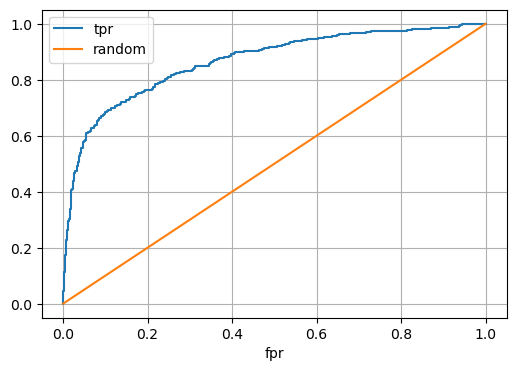

In [236]:
probs = model(X_test).cpu().data.numpy()
fpr, tpr, thr = roc_curve(y_test.cpu(), probs)
roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thr':thr});
roc['random'] = roc['fpr'].copy()
roc['diff'] = roc['tpr'] - roc['fpr']
roc.plot(x='fpr', y=['tpr','random'], figsize=(6,4), grid=True)

In [237]:
roc = roc.sort_values('diff', ascending=False).reset_index().drop('index', axis=1)

In [238]:
roc

,fpr,tpr,thr,random,diff
0,0.113537,0.697719,0.606536,0.113537,0.584182
1,0.100437,0.684411,0.640064,0.100437,0.583974
2,0.106259,0.690114,0.627071,0.106259,0.583855
3,0.104803,0.688213,0.627856,0.104803,0.583409
4,0.103348,0.686312,0.629740,0.103348,0.582964
...,...,...,...,...,...
345,0.991266,1.000000,0.030424,0.991266,0.008734
346,0.991266,0.998099,0.030458,0.991266,0.006832
347,0.000000,0.001901,0.993945,0.000000,0.001901
348,0.000000,0.000000,1.993945,0.000000,0.000000


In [249]:
probs = model(X_test).cpu().data.numpy()
preds = (probs >= roc['thr'].loc[0]).astype('int64')
print(f'accuracy_test: {accuracy_score(y_test.cpu(), preds)}')
print(f'roc_auc_test: {roc_auc_score(y_test.cpu(), probs)}')
f1_scoree = f1_score(y_test.cpu(), preds, average='macro')
print(f'f1 score: {f1_scoree}')
print(confusion_matrix(y_test.cpu(), preds))
print(classification_report(y_test.cpu(), preds))

accuracy_test: 0.7996702390766695
roc_auc_test: 0.8585739507751231
f1 score: 0.7904834407006276
[[612  75]
 [168 358]]
              precision    recall  f1-score   support

         0.0       0.78      0.89      0.83       687
         1.0       0.83      0.68      0.75       526

    accuracy                           0.80      1213
   macro avg       0.81      0.79      0.79      1213
weighted avg       0.80      0.80      0.80      1213



In [220]:
test_data_torch = torch.tensor(test_data.values).cuda()
probs = model(test_data_torch.float()).cpu().data.numpy()
predictions = (probs >= roc['thr'].loc[0]).astype('int64')

In [221]:
sample_sumbission = pd.read_csv('C:/datasets/nlp-getting-started/sample_submission.csv') 

In [222]:
sample_sumbission['target'] = predictions

sample_sumbission.to_csv('C:/datasets/nlp-getting-started/submit01.csv', index=False)

pd.read_csv('C:/datasets/nlp-getting-started/submit01.csv')

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
